# Простые технические индикаторы с библиотекой TA-Lib

In [251]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


import datetime as dt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.main import check_and_make_directories

from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

from finrl.config_tickers import DOW_30_TICKER

import talib

from sklearn.metrics import roc_auc_score, f1_score

%matplotlib inline

Загружаем исходные данные

In [215]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2019-01-01'
TEST_START_DATE = '2019-01-01'
TEST_END_DATE = '2021-01-01'

# загружаем данные
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (88061, 8)


Преобразуем дату и сортируем датасет по дате и бумагам

In [216]:
# преобразуем дату
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

# Отсортируем данные по дате и коду акции
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.740172,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,42.107323,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.098136,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941090,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,30.837591,7117200,CAT,4


Выберем только бумаги Apple

In [217]:
data = df.loc[df['tic'] == 'AAPL']
data.drop(['tic', 'day'], axis=1, inplace=True)
data.head()

,date,open,high,low,close,volume
0,2009-01-02,3.067143,3.251429,3.041429,2.740172,746015200
29,2009-01-05,3.327500,3.435000,3.311071,2.855818,1181608400
58,2009-01-06,3.426786,3.470357,3.299643,2.808715,1289310400
87,2009-01-07,3.278929,3.303571,3.223571,2.748024,753048800
116,2009-01-08,3.229643,3.326786,3.215714,2.799053,673500800


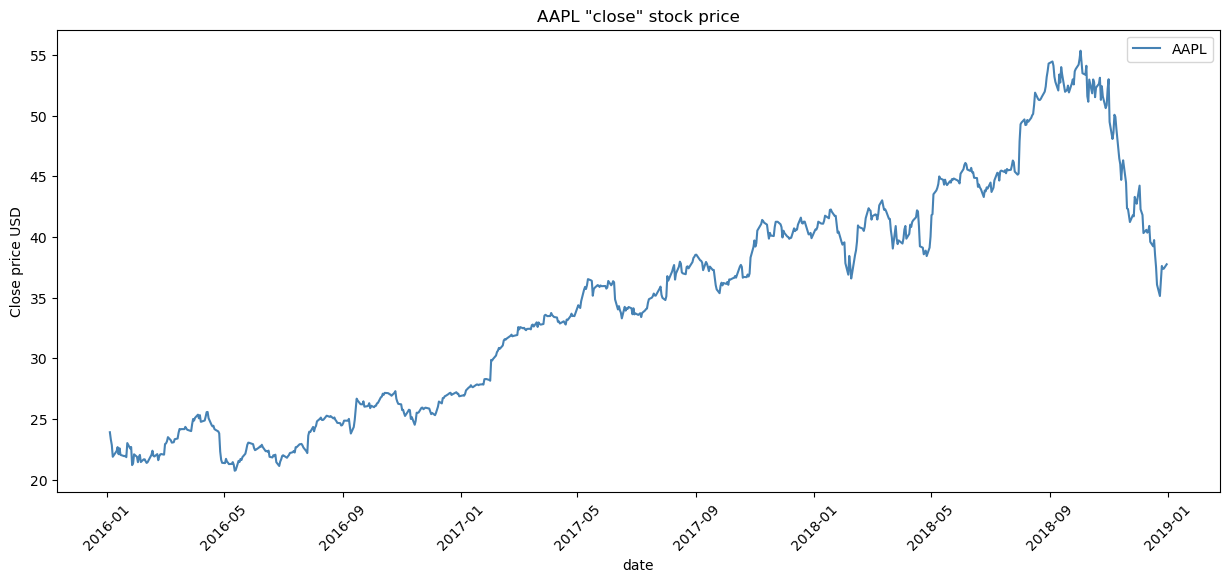

In [250]:
start_day = dt.datetime(2016, 1, 1)
end_day = dt.datetime(2019, 1, 1)
plt.figure(figsize=(15, 6))
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['close'], 
        linestyle='-', color='steelblue', label='AAPL')
plt.title('AAPL "close" stock price')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('Close price USD')
plt.legend()
plt.show()

## Технический анализ

Будем формировать показатели с использованием библиотеки TA-Lib (https://ta-lib.org)

Сколько всего индикаторов есть в библиотеке TA-Lib

In [219]:
len(talib.get_functions())

158

Какие группы индикаторы есть в библиотеке TA-Lib

In [220]:
list(talib.get_function_groups().keys())

['Cycle Indicators',
 'Math Operators',
 'Math Transform',
 'Momentum Indicators',
 'Overlap Studies',
 'Pattern Recognition',
 'Price Transform',
 'Statistic Functions',
 'Volatility Indicators',
 'Volume Indicators']

Посмотрм на индикаторы определенной группы

In [221]:
talib.get_function_groups()['Volatility Indicators']

['ATR', 'NATR', 'TRANGE']

### Простое скользящее среднее (Simple Moving Averages - SMA)

Скользящие средние - один из самых популярных технических индикаторов, используемых для сглаживания ценовых колебаний и выявления трендов. Они могут рассчитываться с использованием различных временных периодов, таких как краткосрочный (10 дней), среднесрочный (50 дней) и долгосрочный (200 дней).

50-дневная SMA/EMA: Один из наиболее популярных периодов, используется для анализа среднесрочных трендов и часто применяется в сочетании с 200-дневной SMA для выявления "золотого пересечения" (golden cross) и "мёртвого пересечения" (death cross).

In [222]:
data["sma_5"] = talib.SMA(data["close"], timeperiod=5)
data["sma_10"] = talib.SMA(data["close"], timeperiod=10)
data["sma_15"] = talib.SMA(data["close"], timeperiod=15)
data["sma_20"] = talib.SMA(data["close"], timeperiod=20)
data["sma_50"] = talib.SMA(data["close"], timeperiod=50)
data["sma_200"] = talib.SMA(data["close"], timeperiod=200)
data["sma_ratio_5_15"] = data['sma_15'] / data['sma_5']
data["sma_ratio_10_50"] = data['sma_50'] / data['sma_15']
data['sma_5_Volume'] = talib.SMA(data["volume"], timeperiod=5)
data['sma_10_Volume'] = talib.SMA(data["volume"], timeperiod=10)
data['sma_15_Volume'] = talib.SMA(data["volume"], timeperiod=15)
data['sma_50_Volume'] = talib.SMA(data["volume"], timeperiod=50)
data["sma_Volume_ratio_5_15"] = data['sma_5_Volume'] / data['sma_15_Volume']
data["sma_Volume_ratio_10_50"] = data['sma_10_Volume'] / data['sma_50_Volume']

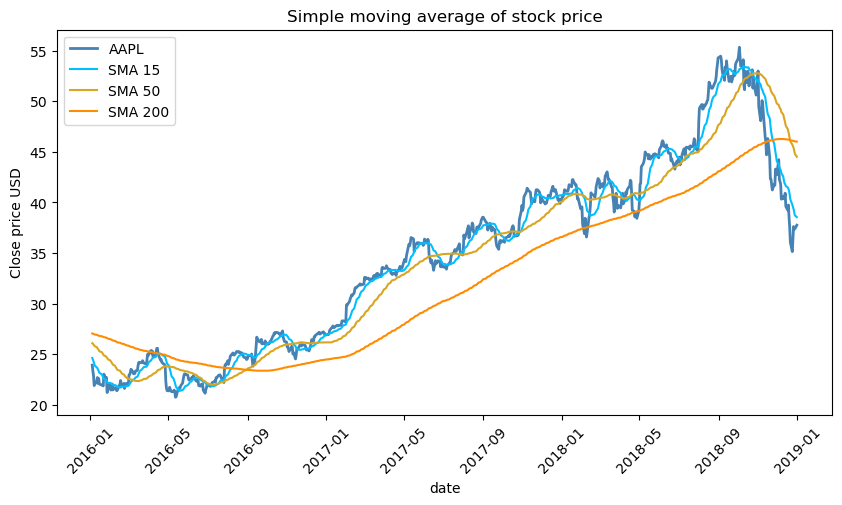

In [223]:
start_day = dt.datetime(2016, 1, 1)
end_day = dt.datetime(2019, 1, 1)
plt.figure(figsize=(10, 5))
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['close'], 
        linestyle='-', linewidth=2, color='steelblue', label='AAPL')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['sma_15'], 
        linestyle='-', color='deepskyblue', label='SMA 15')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['sma_50'], 
        linestyle='-', color='goldenrod', label='SMA 50')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['sma_200'], 
        linestyle='-', color='darkorange', label='SMA 200')
plt.title('Simple moving average of stock price')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('Close price USD')
plt.legend()
# plt.savefig('img/sma.png')
plt.show()

In [224]:
data["ema_5"] = talib.EMA(data["close"], timeperiod=5)
data["ema_10"] = talib.EMA(data["close"], timeperiod=10)
data["ema_20"] = talib.EMA(data["close"], timeperiod=20)
data["ema_50"] = talib.EMA(data["close"], timeperiod=50)
data["ema_200"] = talib.EMA(data["close"], timeperiod=200)

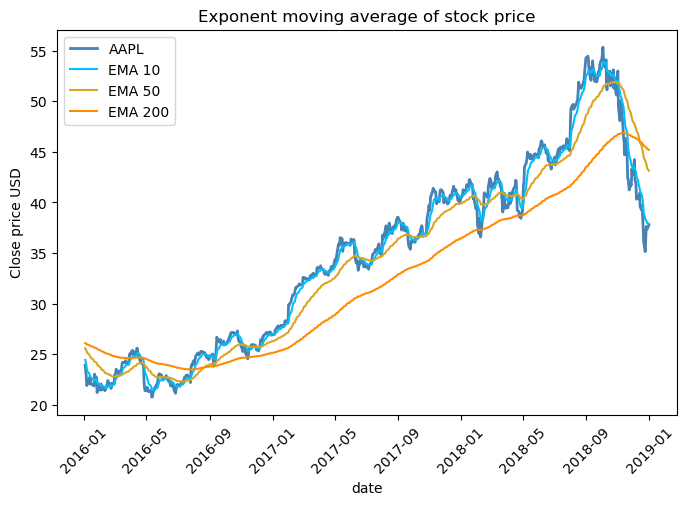

In [225]:
start_day = dt.datetime(2016, 1, 1)
end_day = dt.datetime(2019, 1, 1)
plt.figure(figsize=(8, 5))
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['close'], 
        linestyle='-', linewidth=2, color='steelblue', label='AAPL')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['ema_10'], 
        linestyle='-', color='deepskyblue', label='EMA 10')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['ema_50'], 
        linestyle='-', color='goldenrod', label='EMA 50')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['ema_200'], 
        linestyle='-', color='darkorange', label='EMA 200')
plt.title('Exponent moving average of stock price')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('Close price USD')
plt.legend()
# plt.savefig('img/ema.png')
plt.show()

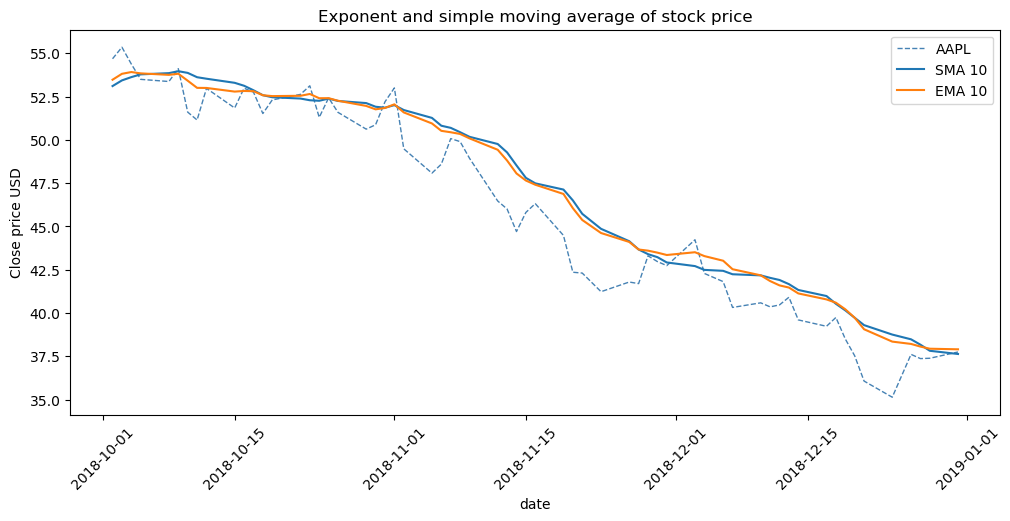

In [226]:
start_day = dt.datetime(2018, 10, 1)
end_day = dt.datetime(2019, 1, 1)
plt.figure(figsize=(12, 5))
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['close'], 
        linestyle='--', linewidth=1, color='steelblue', label='AAPL')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['sma_10'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['ema_10'], 
        linestyle='-', label='EMA 10')
plt.title('Exponent and simple moving average of stock price')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('Close price USD')
plt.legend()
plt.show()

### Полосы Боллинджера (Bollinger Bands)

Полосы Боллинджера используются для измерения волатильности актива и выявления условий перекупленности и перепроданности. Полосы состоят из скользящей средней (обычно 20-дневной скользящей средней) и двух линий стандартного отклонения выше и ниже скользящей средней.

#### Идентификация волатильности:
- Когда полосы расширяются/сужаются, это указывает на увеличение/снижение волатильности.
#### Сигналы на покупку и продажу:
- Когда цена актива пересекает верхнюю полосу, это может быть сигналом перекупленности и возможного разворота вниз.
- Когда цена актива пересекает нижнюю полосу, это может быть сигналом перепроданности и возможного разворота вверх.
#### Торговля на отскок:
- Трейдеры могут использовать полосы Боллинджера для торговли на отскок, покупая, когда цена касается нижней полосы, и продавая, когда она касается верхней полосы.
#### Подтверждение трендов:
- Если цена постоянно прикасается к верхней полосе в восходящем тренде или к нижней полосе в нисходящем тренде, это может служить подтверждением силы текущего тренда.


In [227]:
# Calculate the Bollinger Bands
data["upper_band"], data["middle_band"], data["lower_band"] = talib.BBANDS(data["close"], timeperiod=20)

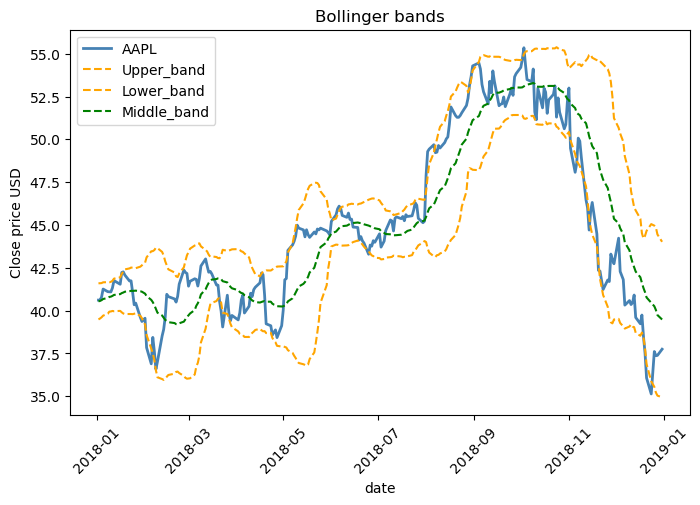

In [228]:
start_day = dt.datetime(2018, 1, 1)
end_day = dt.datetime(2019, 1, 1)
plt.figure(figsize=(8, 5))
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['close'], 
        linestyle='-', linewidth=2, color='steelblue', label='AAPL')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['upper_band'], 
        linestyle='--', color='orange', label='Upper_band')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['lower_band'], 
        linestyle='--', color='orange', label='Lower_band')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['middle_band'], 
        linestyle='--', color='green', label='Middle_band')
plt.title('Bollinger bands')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('Close price USD')
plt.legend()
plt.show()

### Индекс относительной силы (Relative Strength Index - RSI)

RSI - это индикатор импульса, который сравнивает величину недавних достижений с недавними потерями, чтобы определить условия перекупленности и перепроданности. Обычно он используется с 14-дневным периодом.

#### Идентификация волатильности:
- Когда полосы расширяются/сужаются, это указывает на увеличение/снижение волатильности.
#### Определение перекупленности и перепроданности:
- Когда RSI выше 70, это может указывать на перекупленность актива, и трейдеры могут рассматривать возможность продажи.
- Когда RSI ниже 30, это может указывать на перепроданность актива, и трейдеры могут рассматривать возможность покупки.
#### Сигналы на пересечении:
- Некоторые трейдеры используют пересечение уровня 50 в RSI как сигнал на покупку или продажу. Когда RSI пересекает уровень 50 сверху вниз, это может быть сигналом на продажу, и наоборот.

In [229]:
# Calculate the relative strength index (RSI)
data["RSI"] = talib.RSI(data["close"], timeperiod=14)

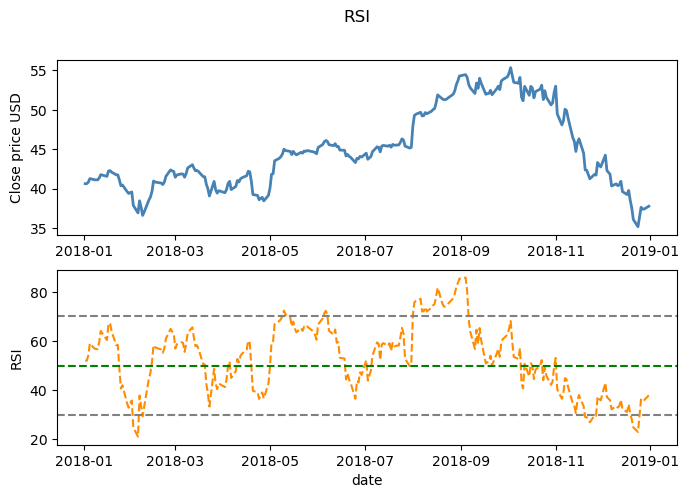

In [249]:
start_day = dt.datetime(2018, 1, 1)
end_day = dt.datetime(2019, 1, 1)

fig, axs = plt.subplots(2, figsize=(8, 5))

axs[0].plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['close'], 
        linestyle='-', linewidth=2, color='steelblue', label='AAPL')
axs[1].plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['RSI'], 
        linestyle='--', color='darkorange', label='RSI')
axs[1].axhline(y=30, color='grey', linestyle='--')
axs[1].axhline(y=70, color='grey', linestyle='--')
axs[1].axhline(y=50, color='green', linestyle='--')

axs[1].set_xlabel('date')
axs[0].set_ylabel('Close price USD')
axs[1].set_ylabel('RSI')

fig.suptitle('RSI')
plt.show()

### Дивергенция сходимости скользящих средних (Moving Average Convergence Divergence - MACD)

MACD - это индикатор следования за трендом, который измеряет разницу между краткосрочной скользящей средней и долгосрочной скользящей средней. Обычно он используется с 12-дневной и 26-дневной скользящей средней, а также с 9-дневной сигнальной линией.

#### Пересечение MACD и сигнальной линии:
- Когда линия MACD пересекает сигнальную линию снизу вверх, это считается бычьим сигналом на покупку.
- Когда линия MACD пересекает сигнальную линию сверху вниз, это считается медвежьим сигналом на продажу.
#### Положение линии MACD относительно нулевой линии:
- Когда линия MACD находится выше нулевой линии, это указывает на восходящий тренд.
- Когда линия MACD находится ниже нулевой линии, это указывает на нисходящий тренд.


In [231]:
# Calculate the MACD
data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data["close"], fastperiod=12, slowperiod=26, signalperiod=9)

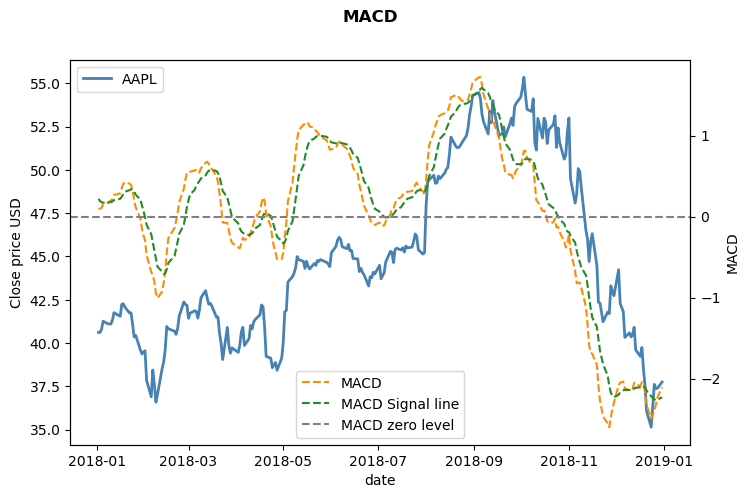

In [232]:
start_day = dt.datetime(2018, 1, 1)
end_day = dt.datetime(2019, 1, 1)

fig, ax = plt.subplots(figsize=(8, 5))

ax2 = ax.twinx()

ax.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['close'], 
        linestyle='-', linewidth=2, color='steelblue', label='AAPL')
ax2.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['macd'], 
        linestyle='--', color='darkorange', label='MACD')
ax2.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['macd_signal'], 
        linestyle='--', color='forestgreen', label='MACD Signal line')
ax2.axhline(y=0, color='grey', linestyle='--', label='MACD zero level')

ax.set_xlabel('date')
ax.set_ylabel('Close price USD')
ax2.set_ylabel('MACD')

fig.suptitle('MACD', fontweight="bold")
ax.legend(loc='upper left')
ax2.legend(loc='lower center')
plt.show()

### Индекс средней направленности (ADX)

Индекс средней направленности был разработан Уайлдером для оценки силы тренда в ценах на акции. 

Два его основных компонента, +DI и -DI, помогают определить направление тренда. Как правило, ADX 25 или выше указывает на сильный тренд, а ADX менее 20 - на слабый.

#### Сила тренда:
- Значения выше 25 указывают на сильный тренд.
- Значения ниже 20 указывают на слабый тренд.


In [235]:
data['ADX_5'] = talib.ADX(data['high'], data['low'], data['close'], timeperiod=5)
data['ADX_15'] = talib.ADX(data['high'], data['low'], data['close'], timeperiod=15)

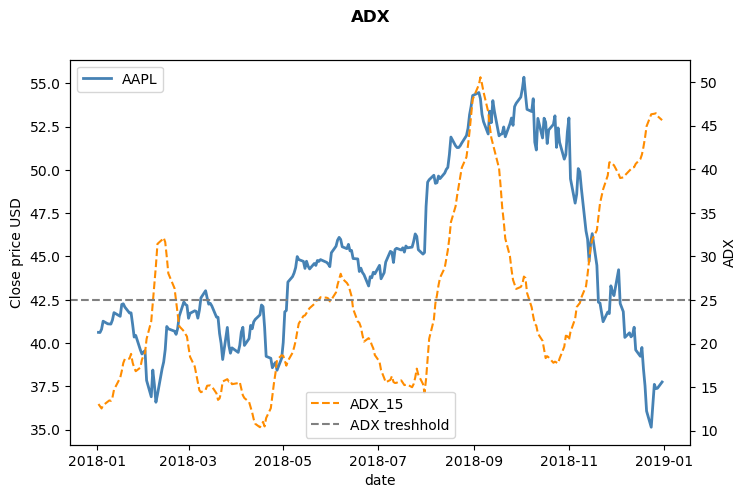

In [236]:
start_day = dt.datetime(2018, 1, 1)
end_day = dt.datetime(2019, 1, 1)

fig, ax = plt.subplots(figsize=(8, 5))

ax2 = ax.twinx()

ax.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['close'], 
        linestyle='-', linewidth=2, color='steelblue', label='AAPL')
ax2.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
        data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['ADX_15'], 
        linestyle='--', color='darkorange', label='ADX_15')
ax2.axhline(y=25, color='grey', linestyle='--', label='ADX treshhold')

ax.set_xlabel('date')
ax.set_ylabel('Close price USD')
ax2.set_ylabel('ADX')

fig.suptitle('ADX', fontweight="bold")
ax.legend(loc='upper left')
ax2.legend(loc='lower center')
plt.show()